<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/learned_image_compression/blob/main/notebooks/RateDistortionOptimizedAutoencoder_CIFAR10_noflatten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rate/Distortion Optimized Autoencoder
Based on [Learned data compression](https://www.tensorflow.org/tutorials/generative/data_compression).

In [1]:
# We minimize: J = R + LAMBDA*D
# Notice that, if LAMBDA is high, we basically minimize D at the expense of increasing R as much as necessary), and viceversa.

In [2]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 883.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: te

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds
from keras.callbacks import Callback
import numpy as np
import keras
import os
from IPython.display import display, clear_output

In [4]:
training_dataset, validation_dataset = tfds.load(
    "cifar10",
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)
print(len(training_dataset), len(validation_dataset))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete6EVVNI/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete6EVVNI/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
40000 10000


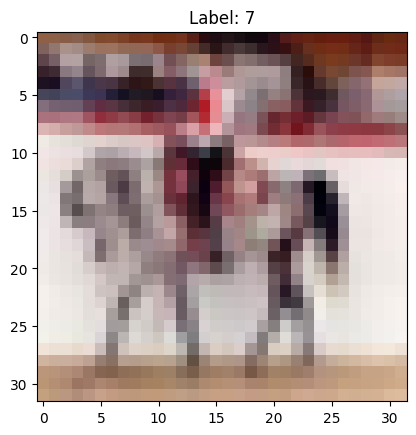

In [5]:
for image, label in training_dataset.take(1):
    # Display the image
    plt.imshow(image)
    plt.title(f"Label: {label.numpy()}")
    plt.show()

In [6]:
PRE_LATENT_SIZE = 2000
LATENT_SIZE = 100
EPOCHS = 100
LAMBDA = 500 #10000

# Original proposal.
#
# Analysis Transform architecture:
#
#            Ouput
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0  32*32*3      - Input: (height * width * depth)
#      20 16*16*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters
#      50   8*8*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*50 + 50 = 25050 parameters
#    2000     2000   fc_1 Dense(units=2000), 8*8*50*2000 + 2000 = 3200*2000 + 2000 = 6402000 parameters
#     100      100   fc_2 Dense(units=100), 2000*100 + 100 = 200100 parameters

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0      100      - Input: (100)
#    2000     2000   fc_1 Dense(units=2000), 100*2000 + 2000 = 202000 parameters
#    3200     3200   fc_2 Dense(units=3200), 2000*3200 + 3200 = 6403200 parameters, 8*8*50 = 3200
#      20 16*16*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 50 input channels of size 8*8, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*3 + 3 = 1503 parameters

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          3200, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# R=0.31640625 D=19.109853744506836, epoch 10, LAMBDA=500

In [7]:
PRE_LATENT_SIZE = 2000
LATENT_SIZE = 100
EPOCHS = 10

# Same architecture, but using strides=1.
#
# Analysis Transform architecture:
#
#            Ouput
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0  32*32*3      - Input: (height * width * depth)
#      20 32*32*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=(1, 1), padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters
#      50 32*32*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=(1, 1), padding="yes"), 20 input channels of size 32*32, 5*5*20*50 + 50 = 25050 parameters
#    2000     2000   fc_1 Dense(units=2000), 32*32*50*2000 + 2000 = 51200*2000 + 2000 = 102402000 parameters
#     100      100   fc_2 Dense(units=100), 2000*100 + 100 = 200100 parameters

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0      100      - Input: (100)
#    2000     2000   fc_1 Dense(units=2000), 100*2000 + 2000 = 202000 parameters
#    3200     3200   fc_2 Dense(units=3200), 2000*51200 + 51200 = 102451200 parameters, 32*32*50 = 51200
#      20 32*32*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(1, 1), padding="yes"), 50 input channels of size 32*32, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(1, 1), padding="yes"), 20 input channels of size 32*32, 5*5*20*3 + 3 = 1503 parameters

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          51200, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((32, 32, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# R=0.3193359375 D=18.908967971801758, epoch 6, LAMBDA=500

In [8]:
EPOCHS = 1
LAMBDA = 500 #10000
LATENT_SIZE = 8*8*50

# Using only convolutional layers, strides=(2, 2).
#
# Analysis Transform architecture:
#
#            Ouput
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0  32*32*3      - Input: (height * width * depth)
#      20 16*16*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=2, padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters
#      50   8*8*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=2, padding="yes"), 20 input channels of size 16*16, 5*5*20*50 + 50 = 25050 parameters

def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0   8*8*50      - Input: (3200)
#      20 16*16*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 50 input channels of size 8*8, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*3 + 3 = 1503 parameters

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((8, 8, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# R=9.2236328125 D=6.935627460479736, epoch 25, LAMBDA=500

In [51]:
EPOCHS = 1
LAMBDA = 500 #10000
LATENT_SIZE = 8*8*50

# Using only convolutional layers, strides=(2, 2).
#
# Analysis Transform architecture:
#
#            Ouput
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0  32*32*3      - Input: (height * width * depth)
#      20 16*16*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=2, padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters
#      50   8*8*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=2, padding="yes"), 20 input channels of size 16*16, 5*5*20*50 + 50 = 25050 parameters

def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2")
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0   8*8*50      - Input: (3200)
#      20 16*16*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 50 input channels of size 8*8, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*3 + 3 = 1503 parameters

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# R= D=, epoch --, LAMBDA=---

In [33]:
'''EPOCHS = 100
LAMBDA = 500 #10000
LATENT_SIZE = 32*32*50

# Using only convolutional layers, strides=1.
#
# Analysis Transform architecture:
#
#            Ouput
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0  32*32*3      - Input: (height * width * depth)
#      20 32*32*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=(1, 1), padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters
#      50 32*32*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=(1, 1), padding="yes"), 20 input channels of size 32*32, 5*5*20*50 + 50 = 25050 parameters

def make_analysis_transform(latent_dims=100):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0 32*32*50      - Input: (3200)
#      20 32*32*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 50 input channels of size 8*8, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*3 + 3 = 1503 parameters

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((32, 32, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# R=141.14453125 D=5.647729873657227, epoch 10, LAMBDA=500'''

'EPOCHS = 100\nLAMBDA = 500 #10000\nLATENT_SIZE = 32*32*50\n\n# Using only convolutional layers, strides=1.\n#\n# Analysis Transform architecture:\n#\n#            Ouput\n#  Number  Feature\n#      of      Map\n# Neurons    Shape   Name Info\n# ======= ======== ====== =============...\n#       0  32*32*3      - Input: (height * width * depth)\n#      20 32*32*20 conv_1 Conv2D(filters=20, kernel_size=5, strides=(1, 1), padding="yes"), 3 input channels of size 32*32, 5*5*3*20 + 20 = 1520 parameters\n#      50 32*32*50 conv_2 Conv2D(filters=50, kernel_size=5, strides=(1, 1), padding="yes"), 20 input channels of size 32*32, 5*5*20*50 + 50 = 25050 parameters\n\ndef make_analysis_transform(latent_dims=100):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          20, 5, use_bias=True, strides=1, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          50, 5, use_bias=Tr

In [34]:
'''EPOCHS = 100
LAMBDA = 500 #10000
PRE_LATENT_SIZE = 4096
LATENT_SIZE = 256

# Original proposal.
#
# Analysis Transform architecture:
#
#             Ouput
#  Number   Feature
#      of       Map
# Neurons     Shape   Name Info
# ======= ========= ====== =============...
#       0   32*32*3      - Input: (height * width * depth)
#     256 16*16*256 conv_1 Conv2D(filters=256, kernel_size=5, strides=(2, 2), padding="yes"), 3 input channels of size 32*32, 5*5*3*256 + 256 = 19456 parameters
#     256   8*8*256 conv_2 Conv2D(filters=256, kernel_size=5, strides=(2, 2), padding="yes"), 256 input channels of size 16*16, 5*5*256*256 + 256 = 1638656 parameters
#    4096      4096   fc_1 Dense(units=4096), 8*8*256*4096 + 4096 = 16384*4096 + 4096 = 67112960 parameters
#     256       256   fc_2 Dense(units=256), 4096*256 + 256 = 1048832 parameters

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

# Synthesis Transform architecture:
#
#           Output
#  Number  Feature
#      of      Map
# Neurons    Shape   Name Info
# ======= ======== ====== =============...
#       0      256      - Input: (256)
#    4096     4096   fc_1 Dense(units=4096), 256*4096 + 4096 = 1052672 parameters
# 8*8*256    16384   fc_2 Dense(units=8*8*256), 2000*3200 + 3200 = 6403200 parameters, 8*8*50 = 3200 <------------------
#      20 16*16*20 conv_1 Conv2DTranspose(filters=20, kernel_size=5, strides=(2, 2), padding="yes"), 50 input channels of size 8*8, 5*5*50*20 + 20 = 25020 parameters
#       3  32*32*3 conv_2 Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding="yes"), 20 input channels of size 16*16, 5*5*20*3 + 3 = 1503 parameters

___________________________
Model: "synthesis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #
=================================================================
 fc_1 (Dense)                (None, 4096)              1052672

 fc_2 (Dense)                (None, 16384)             67125248

 reshape (Reshape)           (None, 8, 8, 256)         0

 conv_1 (Conv2DTranspose)    (None, 16, 16, 256)       1638656

 conv_2 (Conv2DTranspose)    (None, 32, 32, 3)         19203

=================================================================
Total params: 69835779 (266.40 MB)
Trainable params: 69835779 (266.40 MB)
Non-trainable params: 0 (0.00 Byte)

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          256*8*8, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 256)),
      tf.keras.layers.Conv2DTranspose(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

# R=0.80078125 D=17.01704216003418, epoch 17, LAMBDA=500'''

'EPOCHS = 100\nLAMBDA = 500 #10000\nPRE_LATENT_SIZE = 4096\nLATENT_SIZE = 256\n\n# Original proposal.\n#\n# Analysis Transform architecture:\n#\n#             Ouput\n#  Number   Feature\n#      of       Map\n# Neurons     Shape   Name Info\n# ======= ========= ====== =============...\n#       0   32*32*3      - Input: (height * width * depth)\n#     256 16*16*256 conv_1 Conv2D(filters=256, kernel_size=5, strides=(2, 2), padding="yes"), 3 input channels of size 32*32, 5*5*3*256 + 256 = 19456 parameters\n#     256   8*8*256 conv_2 Conv2D(filters=256, kernel_size=5, strides=(2, 2), padding="yes"), 256 input channels of size 16*16, 5*5*256*256 + 256 = 1638656 parameters\n#    4096      4096   fc_1 Dense(units=4096), 8*8*256*4096 + 4096 = 16384*4096 + 4096 = 67112960 parameters\n#     256       256   fc_2 Dense(units=256), 4096*256 + 256 = 1048832 parameters\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequ

In [35]:
'''PRE_LATENT_SIZE = 2000
LATENT_SIZE = 100

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          64, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          128*8*8, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 128)),
      tf.keras.layers.Conv2DTranspose(
          64, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder'''

'PRE_LATENT_SIZE = 2000\nLATENT_SIZE = 100\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          64, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          128, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_2"),\n      tf.keras.layers.Flatten(),\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),\n      tf.keras.layers.Dense(\n          latent_dims, use_bias=True, activation=None, name="fc_2"),\n  ], name="analysis_transform")\n  return encoder\n\ndef make_synthesis_transform():\n  """Creates the synthesis (decoder) transform."""\n  decoder = tf.keras.Sequential([\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1

In [36]:
'''PRE_LATENT_SIZE = 4096
LATENT_SIZE = 256

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Conv2D(
          512, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_3"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          512*4*4, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((4, 4, 512)),
      tf.keras.layers.Conv2DTranspose(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_3"),
  ], name="synthesis_transform")
  return decoder'''

'PRE_LATENT_SIZE = 4096\nLATENT_SIZE = 256\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          128, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          256, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_2"),\n      tf.keras.layers.Conv2D(\n          512, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_3"),\n      tf.keras.layers.Flatten(),\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),\n      tf.keras.layers.Dense(\n          latent_dims, use_bias=True, activation=None, name="fc_2"),\n  ], name="analysis_transform")\n  return encoder\n\ndef make_synthesis_transform():\n  """Creates the synthesis (decoder) transform.""

In [37]:
'''PRE_LATENT_SIZE = 4096
LATENT_SIZE = 256

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          256*8*8, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 256)),
      tf.keras.layers.Conv2DTranspose(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder'''

'PRE_LATENT_SIZE = 4096\nLATENT_SIZE = 256\n\ndef make_analysis_transform(latent_dims=LATENT_SIZE):\n  """Creates the analysis (encoder) transform."""\n  encoder = tf.keras.Sequential([\n      tf.keras.layers.Conv2D(\n          128, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_1"),\n      tf.keras.layers.Conv2D(\n          256, 5, use_bias=True, strides=2, padding="same",\n          activation="leaky_relu", name="conv_2"),\n      tf.keras.layers.Flatten(),\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),\n      tf.keras.layers.Dense(\n          latent_dims, use_bias=True, activation=None, name="fc_2"),\n  ], name="analysis_transform")\n  return encoder\n\ndef make_synthesis_transform():\n  """Creates the synthesis (decoder) transform."""\n  decoder = tf.keras.Sequential([\n      tf.keras.layers.Dense(\n          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_

In [38]:
class CompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor."""

  def __init__(self, latent_dims=LATENT_SIZE, images_width=32, images_height=32):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    #self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))
    self.prior_log_scales = tf.Variable(tf.zeros((8, 8, 50)))
    self.images_width = images_width
    self.images_height = images_height

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""

    print("CompressionTrainer.call: x.shape=", x.shape)

    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    print(x.shape)
    x = tf.reshape(x, (-1, self.images_width, self.images_height, 3))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    #entropy_model = tfc.ContinuousBatchedEntropyModel(self.prior, coding_rank=1, compression=False)
    entropy_model = tfc.ContinuousBatchedEntropyModel(self.prior, coding_rank=3, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per image.
    rate = tf.reduce_mean(rate)

    # Divide rate by the number of neurons in the latent space. This normalizes the rate in bits/neuron.
    rate /= tf.cast(tf.shape(y)[1], dtype=tf.float32)

    # Mean absolute difference across pixels.
    #distortion = tf.reduce_mean(abs(x - x_tilde))
    distortion = tf.sqrt(tf.reduce_mean((x - x_tilde)*(x - x_tilde))) # RMSE
    #distortion = tf.reduce_mean((x - x_tilde)*(x - x_tilde))
    #tf.print(rate, distortion)

    return dict(rate=rate, distortion=distortion)

In [39]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_compression_trainer(lmbda, latent_dims=LATENT_SIZE, images_width=32, images_height=32):
  trainer = CompressionTrainer(latent_dims, images_width, images_height)
  #custom_metric = MeanMetricWrapper()
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

In [40]:
class MyCallback(Callback):
    def __init__(self, file_prefix='model_parameters'):
        super(MyCallback, self).__init__()
        self.file_prefix = file_prefix
        self.losses = []

    def on_train_begin(self, logs=None):
        prev_trained_model = os.path.exists("autoencoder_weights.h5")
        if prev_trained_model:
            print(f"Using weights previously generated")
            #self.model = tf.keras.models.load_model("model", custom_objects={'MeanMetricWrapper': MeanMetricWrapper, 'pass_through_loss': pass_through_loss})
            #self.model = keras.models.load_model("model", custom_objects=dict(rate=pass_through_loss, distortion=pass_through_loss))
            x_batch_ = validation_dataset.batch(1).skip(3).take(1)
            # Extract the element from the batch to get a tensor
            x_ = next(iter(x_batch_))
            x_image, _ = x_
            #print(x_)
            _ = self.model(x_image)
            '''
            self.model = make_compression_trainer(LAMBDA)
            self.model.analysis_transform.summary()
            self.model.synthesis_transform.summary()
            self.model.prior_log_scales.summary()
            # Build the model by calling it with dummy input data
            #dummy_input = tf.zeros((1, input_shape))  # Replace input_shape with the actual input shape
            '''
            #self.model.analysis_transform.summary()
            #self.model.synthesis_transform.summary()
            #self.model.load_weights("autoencoder_weights.h5")
            self.model.analysis_transform.load_weights("encoder_weights.h5")
            self.model.synthesis_transform.load_weights("decoder_weights.h5")
        else:
            print("No saved weights found. Training from scratch.")

    def on_epoch_end(self, epoch, logs=None):
        '''
        # Get the model's weights
        model_weights = self.model.get_weights()

        # Save the weights to a file
        file_name = f"{self.file_prefix}_epoch_{epoch + 1}.npy"
        np.save(file_name, model_weights)
        print(f"Saved model parameters at the end of epoch {epoch + 1} to {file_name}")
        '''
        #keras.models.save_model(self.model, "model", custom_objects=dict(rate=pass_through_loss, distortion=pass_through_loss))
        #print("Model saved.")
        self.model.save_weights("autoencoder_weights.h5")
        self.model.analysis_transform.save_weights("encoder_weights.h5")
        self.model.synthesis_transform.save_weights("decoder_weights.h5")

        print("\nSaved weights.")

        x_batch = validation_dataset.batch(1).skip(3).take(1)
        # Extract the element from the batch to get a tensor
        x = next(iter(x_batch))
        x_image, _ = x
        x_image = x_image.numpy().squeeze().astype(np.uint8)
        y = self.model.analysis_transform(x)
        #entropy_model = tfc.ContinuousBatchedEntropyModel(self.model.prior, coding_rank=1, compression=True)
        entropy_model = tfc.ContinuousBatchedEntropyModel(self.model.prior, coding_rank=3, compression=True)
        y_tilde, rate = entropy_model(y, training=False)
        y_tilde_codestream = entropy_model.compress(y)
        x_tilde = self.model.synthesis_transform(y_tilde)[0]
        #rate /= LATENT_SIZE
        #rate /= (32*32)
        #rate = tf.size(y_tilde)/(32*32)
        #print("len=", len(y_tilde_codestream.numpy()[0]))
        bit_rate_in_bits_per_pixel = len(y_tilde_codestream.numpy()[0]) / (32*32)
        distortion = tf.sqrt(tf.reduce_mean((x_image - x_tilde)*(x_image - x_tilde))) # RMSE
        print(f"R={bit_rate_in_bits_per_pixel} D={distortion} D+R={bit_rate_in_bits_per_pixel + distortion} LATENT_SIZE={LATENT_SIZE}")

        #clear_output(wait=True)
        plt.subplot(1, 3, 1)
        plt.imshow(x_image)
        plt.subplot(1, 3, 2)
        plt.imshow(x_tilde.numpy().astype(np.uint8))
        if logs is not None and 'val_loss' in logs:
            self.losses.append(logs['val_loss'])
            plt.subplot(1, 3, 3)
            plt.plot(range(1, len(self.losses) + 1), self.losses, marker='o', linestyle='-', color='b')
            plt.title('Validation Loss Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Loss (J)')

        '''
        fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(6, 2))
        axes = axes.ravel()
        x_batch = validation_dataset.batch(1).skip(3).take(1)
        # Extract the element from the batch to get a tensor
        x = next(iter(x_batch))
        x_image, _ = x
        axes[0].imshow(x_image.numpy().squeeze().astype(np.uint8))
        y = self.model.analysis_transform(x)
        entropy_model = tfc.ContinuousBatchedEntropyModel(self.model.prior, coding_rank=1, compression=False)
        y_tilde, rate = entropy_model(y, training=False)
        x_tilde = self.model.synthesis_transform(y_tilde)[0]
        axes[1].imshow(x_tilde.numpy().astype(np.uint8))
        if logs is not None and 'loss' in logs:
            self.losses.append(logs['loss'])
            clear_output(wait=True)
            axes[2].plot(range(1, len(self.losses) + 1), self.losses, marker='o', linestyle='-', color='b')
            #axes[2].title('Training Loss Over Epochs')
            axes[2].xlabel('Epoch')
            axes[2].ylabel('Loss')
        '''

        plt.tight_layout()
        plt.show()

        #y_tilde, rate = self.model.entropy_model(y, training=training)
        '''
        #x_tilde = self.synthesis_transform(y_tilde)

        # Average number of bits per image.
        rate = tf.reduce_mean(rate)

        # Divide rate by the number of neurons in the latent space. This normalizes the rate in bits/neuron.
        rate /= tf.cast(tf.shape(y)[1], dtype=tf.float32)

        # Mean absolute difference across pixels.
        #distortion = tf.reduce_mean(abs(x - x_tilde))
        distortion = tf.sqrt(tf.reduce_mean((x - x_tilde)*(x - x_tilde))) # RMSE
        '''

In [41]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def __train_model(lmbda=LAMBDA, epochs=EPOCHS):
  callbacks_list = [MyCallback()]
  trainer = make_compression_trainer(lmbda)
  for i in range(EPOCHS):
    trainer.fit(
        training_dataset.map(add_rd_targets).batch(128).prefetch(8),
        epochs=1,
        validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
        validation_freq=1,
        verbose=1,
        callbacks=callbacks_list
    )
  return trainer

Epoch: 0
Using weights previously generated
CompressionTrainer.call: x.shape= (1, 32, 32, 3)
(1, 32, 32, 3)
CompressionTrainer.call: x.shape= (None, 32, 32, 3)
(None, 32, 32, 3)
CompressionTrainer.call: x.shape= (None, 32, 32, 3)
(None, 32, 32, 3)
313/313 [==============================] - ETA: 0s - loss: 799.8132 - distortion_loss: 0.0986 - rate_loss: 750.5100 - distortion_pass_through_loss: 0.0986 - rate_pass_through_loss: 750.3873

CompressionTrainer.call: x.shape= (None, 32, 32, 3)
(None, 32, 32, 3)

Saved weights.
R=7.4931640625 D=17.82343101501465 D+R=25.31659507751465 LATENT_SIZE=3200


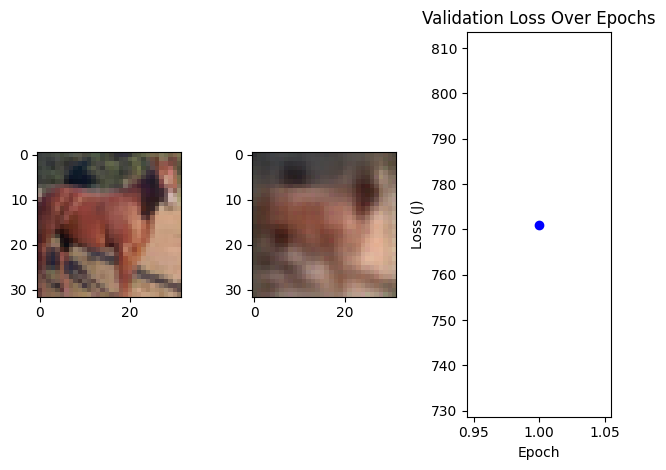

313/313 [==============================] - 87s 269ms/step - loss: 799.8132 - distortion_loss: 0.0986 - rate_loss: 750.5100 - distortion_pass_through_loss: 0.0986 - rate_pass_through_loss: 750.3873 - val_loss: 771.0690 - val_distortion_loss: 0.2388 - val_rate_loss: 651.6518 - val_distortion_pass_through_loss: 0.2388 - val_rate_pass_through_loss: 651.6650


In [42]:
callbacks_list = [MyCallback()]
trainer = make_compression_trainer(lmbda=LAMBDA)
print("Epoch:", 0)
trainer.fit(
  training_dataset.map(add_rd_targets).batch(128).prefetch(8),
  epochs=1,
  validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
  validation_freq=1,
    verbose=1,
  callbacks=callbacks_list
)

In [43]:
trainer.summary()
trainer.analysis_transform.summary()
trainer.synthesis_transform.summary()
for i in range(1, EPOCHS):
  print("Epoch:", i)
  trainer.fit(
    training_dataset.map(add_rd_targets).batch(128).prefetch(8),
    epochs=1,
    validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
    validation_freq=1,
    verbose=1,
    callbacks=callbacks_list
  )
#trainer = train_model(lmbda=LAMBDA)

Model: "compression_trainer_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 analysis_transform (Sequen  (None, 8, 8, 50)          26570     
 tial)                                                           
                                                                 
 synthesis_transform (Seque  (None, 32, 32, 3)         26523     
 ntial)                                                          
                                                                 
Total params: 56293 (219.89 KB)
Trainable params: 56293 (219.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "analysis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 16, 16, 20)        1520      
                                             

In [44]:
!ls -l *.h5

-rw-r--r-- 1 root root 241684 Dec 20 06:18 autoencoder_weights.h5
-rw-r--r-- 1 root root 120336 Dec 20 06:18 decoder_weights.h5
-rw-r--r-- 1 root root 120336 Dec 20 06:18 encoder_weights.h5


In [22]:
class Compressor(tf.keras.Model):
  """Compresses images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

class Decompressor(tf.keras.Model):
  """Decompresses images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

def make_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  #entropy_model = tfc.ContinuousBatchedEntropyModel(trainer.prior, coding_rank=1, compression=True, **kwargs)
  entropy_model = tfc.ContinuousBatchedEntropyModel(trainer.prior, coding_rank=3, compression=True, **kwargs)
  compressor = Compressor(trainer.analysis_transform, entropy_model)
  decompressor = Decompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_codec(trainer)

In [23]:
def display_images(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((32, 32, 3), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        #.5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        .5, .5, f"{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

String representation of first compressed image (in hexadecimal): 0x9b6bcb078fcd3d4955edbafa7f5010bcd8c309e3930bbd8b58c64b32e651b8202018fafeef0b831f283810082b957de7768793e2f0bbf7f25519175e80165214429170286936211c9c8aee84c0a64ddfe6205fbff93a6870642ed6a02dd5c3473e4a9f158a6c945b6c577670ca8d1ddf21ee0589a233056cbef67474d377847373793816d285cd0b1274d3abe2ea51861af68689da2295fb5ddcc4dbcb7816e40573f5ba46ed8982324f8681d881600ccd5ef188f27c013410e6f6e91daf8bca6e2c4cf4f1830e57370342a3bf0c7ada5bfda6e4337a8eccd374417389a194c851362833f90eef15cd5a3af1c00568586db1a3b910bd45b99086b9fff467534ba9b95ab018c7873215102d88ae7551110d77896372044fdcfb025c078f2c14d0f33ae73aa3aa5abdb6963937446140ce1fbf27a5f715c4b9806e823dea1c30f368bbe351b25b486f4aa59568eb0b96a0e5b7af7f6890b702aae956808bea325336a220f50c917237995002be73d10920cc377309774f54c7617bafa9022c89a0c8736ae3d7d8c8ba2cd6f9d3ded4ecde4319551a24ce1b9e61bc61940724edd6796c6ddb7611910a15cb23517e372ccbaf0ab61f8e186276c1dfae21b607e07561ee33de89c4a13568e795f104403eb9ddd1

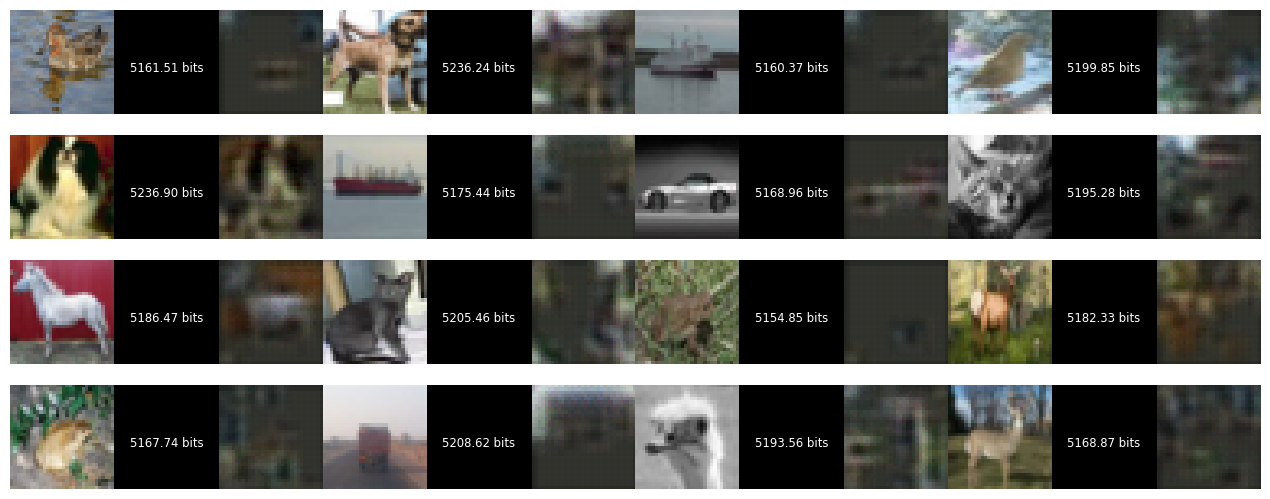

In [24]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)
strings, entropies = compressor(originals)

print(f"String representation of first compressed image (in hexadecimal): 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")

reconstructions = decompressor(strings)
display_images(originals, strings, entropies, reconstructions)

In [25]:
def save_compressed_images(strings):
  for count, i in enumerate(strings):
    code_stream_length_in_bytes = len(i.numpy())
    print(count, code_stream_length_in_bytes, code_stream_length_in_bytes*8, i.dtype)
    file_path = f"{count:02d}.lic"
    with open(file_path, "wb") as file:
      file.write(i.numpy())

save_compressed_images(strings)
!ls -l *.lic

0 646 5168 <dtype: 'string'>
1 655 5240 <dtype: 'string'>
2 645 5160 <dtype: 'string'>
3 650 5200 <dtype: 'string'>
4 655 5240 <dtype: 'string'>
5 648 5184 <dtype: 'string'>
6 647 5176 <dtype: 'string'>
7 650 5200 <dtype: 'string'>
8 649 5192 <dtype: 'string'>
9 651 5208 <dtype: 'string'>
10 645 5160 <dtype: 'string'>
11 648 5184 <dtype: 'string'>
12 647 5176 <dtype: 'string'>
13 652 5216 <dtype: 'string'>
14 649 5192 <dtype: 'string'>
15 647 5176 <dtype: 'string'>
-rw-r--r-- 1 root root 646 Dec 20 06:10 00.lic
-rw-r--r-- 1 root root 655 Dec 20 06:10 01.lic
-rw-r--r-- 1 root root 645 Dec 20 06:10 02.lic
-rw-r--r-- 1 root root 650 Dec 20 06:10 03.lic
-rw-r--r-- 1 root root 655 Dec 20 06:10 04.lic
-rw-r--r-- 1 root root 648 Dec 20 06:10 05.lic
-rw-r--r-- 1 root root 647 Dec 20 06:10 06.lic
-rw-r--r-- 1 root root 650 Dec 20 06:10 07.lic
-rw-r--r-- 1 root root 649 Dec 20 06:10 08.lic
-rw-r--r-- 1 root root 651 Dec 20 06:10 09.lic
-rw-r--r-- 1 root root 645 Dec 20 06:10 10.lic
-rw-r--r-- 1 

[<tf.Tensor: shape=(), dtype=string, numpy=b'\x9bk\xcb\x07\x8f\xcd=IU\xed\xba\xfa\x7fP\x10\xbc\xd8\xc3\t\xe3\x93\x0b\xbd\x8bX\xc6K2\xe6Q\xb8  \x18\xfa\xfe\xef\x0b\x83\x1f(8\x10\x08+\x95}\xe7v\x87\x93\xe2\xf0\xbb\xf7\xf2U\x19\x17^\x80\x16R\x14B\x91p(i6!\x1c\x9c\x8a\xee\x84\xc0\xa6M\xdf\xe6 _\xbf\xf9:hpd.\xd6\xa0-\xd5\xc3G>J\x9f\x15\x8al\x94[lWvp\xca\x8d\x1d\xdf!\xee\x05\x89\xa23\x05l\xbe\xf6tt\xd3w\x84ssy8\x16\xd2\x85\xcd\x0b\x12t\xd3\xab\xe2\xeaQ\x86\x1a\xf6\x86\x89\xda"\x95\xfb]\xdc\xc4\xdb\xcbx\x16\xe4\x05s\xf5\xbaF\xed\x89\x822O\x86\x81\xd8\x81`\x0c\xcd^\xf1\x88\xf2|\x014\x10\xe6\xf6\xe9\x1d\xaf\x8b\xcan,L\xf4\xf1\x83\x0eW7\x03B\xa3\xbf\x0cz\xda[\xfd\xa6\xe43z\x8e\xcc\xd3tAs\x89\xa1\x94\xc8Q6(3\xf9\x0e\xef\x15\xcdZ:\xf1\xc0\x05hXm\xb1\xa3\xb9\x10\xbdE\xb9\x90\x86\xb9\xff\xf4gSK\xa9\xb9Z\xb0\x18\xc7\x872\x15\x10-\x88\xaeuQ\x11\rw\x89cr\x04O\xdc\xfb\x02\\\x07\x8f,\x14\xd0\xf3:\xe7:\xa3\xaaZ\xbd\xb6\x9697Da@\xce\x1f\xbf\'\xa5\xf7\x15\xc4\xb9\x80n\x82=\xea\x1c0\xf3h\xbb\xe3Q\xb2[HoJ\xa5

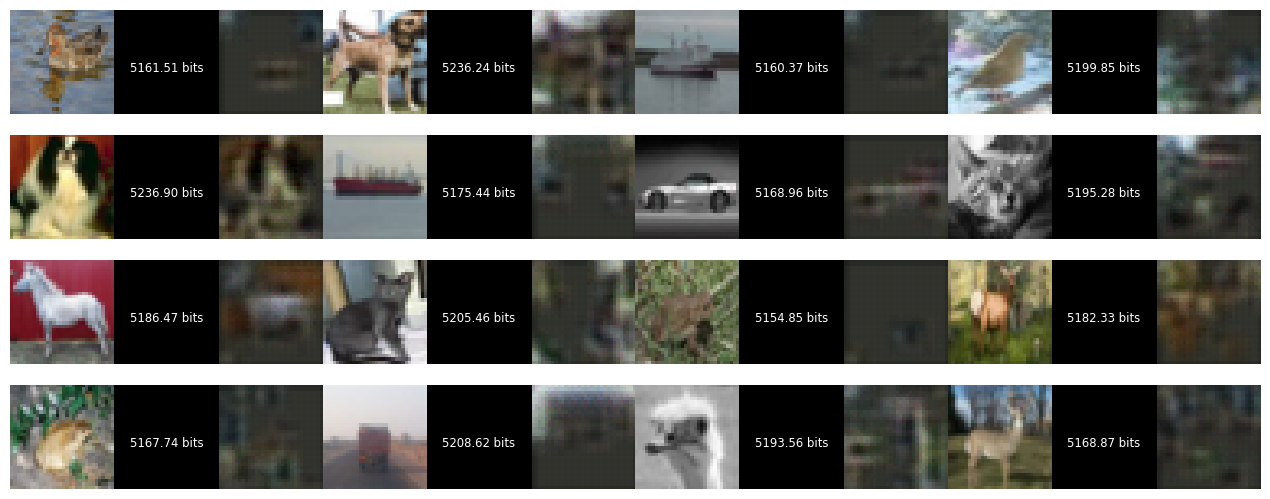

In [26]:
def load_compressed_images():
  strings = []
  for count in range(16):
    file_path = f"{count:02d}.lic"
    with open(file_path, "rb") as file:
      file_contents = tf.io.read_file(file_path)
      strings.append(file_contents)
  return strings

strings = load_compressed_images()
print(strings)
#decompressor.load_weights("decompressor_weights.h5")
reconstructions = decompressor(strings)
display_images(originals, strings, entropies, reconstructions)

In [27]:
# Load the weights into the current model, encode and decode the images
trainer.load_weights("autoencoder_weights.h5")

In [28]:
compressor, decompressor = make_codec(trainer)

In [54]:
strings, entropies = compressor(originals)

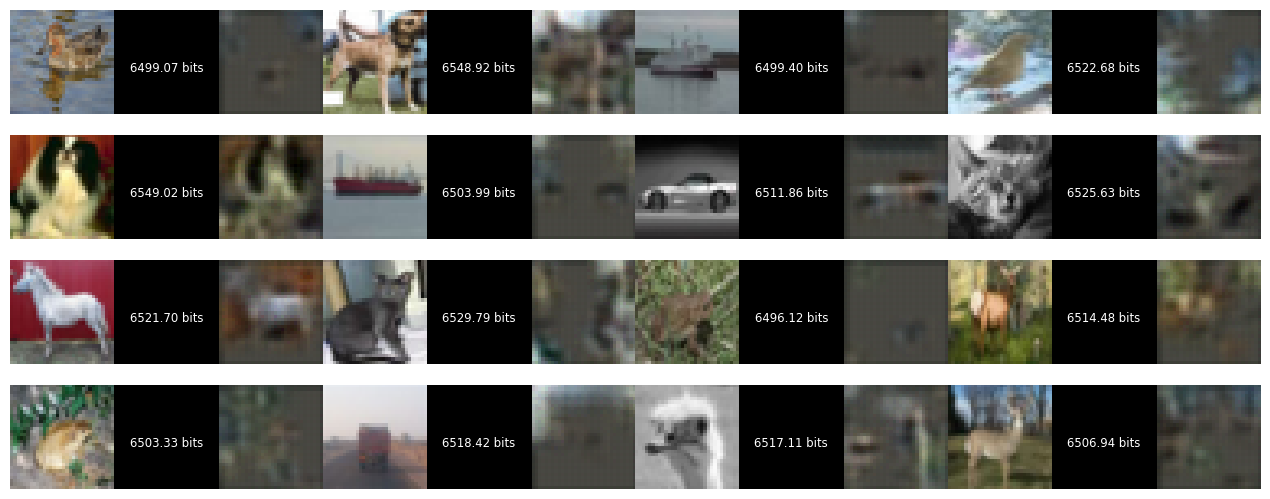

In [55]:
reconstructions = decompressor(strings)
display_images(originals, strings, entropies, reconstructions)

In [63]:
# Load the weights into a different model, where the decoder reshape an input 16x16x50 space

def _make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((8, 8, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

def _add_rd_targets2(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  resized_image = tf.image.resize(image, [64, 64])
  print(resized_image.shape)
  return resized_image, dict(rate=0., distortion=0.)

trainer = make_compression_trainer(lmbda=LAMBDA, images_width=64, images_height=64)
'''trainer.fit(
  training_dataset.map(add_rd_targets2).batch(128).prefetch(8),
  epochs=0,
  validation_data=validation_dataset.map(add_rd_targets2).batch(128).cache(),
  validation_freq=1,
    verbose=1
)'''
input_shape = (32, 32, 3)
#trainer.build()
trainer.analysis_transform.build((None,) + input_shape)
trainer.analysis_transform.load_weights("encoder_weights.h5")
latent_shape = (8, 8, 50)
trainer.synthesis_transform.build((None,) + latent_shape)
#trainer.load_weights("autoencoder_weights.h5")
trainer.synthesis_transform.load_weights("decoder_weights.h5")
compressor, decompressor = make_codec(trainer)

In [64]:
#trainer.summary()
trainer.analysis_transform.summary()
trainer.synthesis_transform.summary()

Model: "analysis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 16, 16, 20)        1520      
                                                                 
 conv_2 (Conv2D)             (None, 8, 8, 50)          25050     
                                                                 
Total params: 26570 (103.79 KB)
Trainable params: 26570 (103.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "synthesis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2DTranspose)    (None, 16, 16, 20)        25020     
                                                                 
 conv_2 (Conv2DTranspose)    (None, 32, 32, 3)         1503      
                                               

In [65]:
input_shape = (32, 32, 3)
#trainer.build()
trainer.analysis_transform.build((None,) + input_shape)
trainer.analysis_transform.load_weights("encoder_weights.h5")
latent_shape = (8, 8, 50)
trainer.synthesis_transform.build((None,) + latent_shape)
#trainer.load_weights("autoencoder_weights.h5")
trainer.synthesis_transform.load_weights("decoder_weights.h5")
compressor, decompressor = make_codec(trainer)

In [66]:
#trainer.summary()
trainer.analysis_transform.summary()
trainer.synthesis_transform.summary()

Model: "analysis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 16, 16, 20)        1520      
                                                                 
 conv_2 (Conv2D)             (None, 8, 8, 50)          25050     
                                                                 
Total params: 26570 (103.79 KB)
Trainable params: 26570 (103.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "synthesis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2DTranspose)    (None, 16, 16, 20)        25020     
                                                                 
 conv_2 (Conv2DTranspose)    (None, 32, 32, 3)         1503      
                                               

In [68]:
input_shape = (64, 64, 3)
#trainer.build()
trainer.analysis_transform.build((None,) + input_shape)
trainer.analysis_transform.load_weights("encoder_weights.h5")
latent_shape = (16, 16, 50)
trainer.synthesis_transform.build((None,) + latent_shape)
#trainer.load_weights("autoencoder_weights.h5")
trainer.synthesis_transform.load_weights("decoder_weights.h5")
compressor, decompressor = make_codec(trainer)

In [62]:
#trainer.summary()
trainer.analysis_transform.summary()
trainer.synthesis_transform.summary()

Model: "analysis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, None, None, 20)    1520      
                                                                 
 conv_2 (Conv2D)             (None, None, None, 50)    25050     
                                                                 
Total params: 26570 (103.79 KB)
Trainable params: 26570 (103.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "synthesis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2DTranspose)    (None, 16, 16, 20)        25020     
                                                                 
 conv_2 (Conv2DTranspose)    (None, 32, 32, 3)         1503      
                                               

In [56]:
input_shape = (64, 64, 3)
#trainer.build()
compressor.build((None,) + input_shape)
compressor.load_weights("encoder_weights.h5")
compressor.summary()

ValueError: ignored

In [59]:
print(originals.shape, type(originals))
resized_images = tf.image.resize(originals, [64, 64])
print(resized_images.shape, type(resized_images))

(16, 32, 32, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 64, 64, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [60]:
strings, entropies = compressor(resized_images)
#strings, entropies = compressor(originals)

InvalidArgumentError: ignored

In [ ]:
reconstructions = decompressor(strings)

In [ ]:
display_images(originals, strings, entropies, reconstructions)

In [ ]:
# Load the weights of the decoder in a reshaped model that expects

In [ ]:
  # Compare with JPEG

(originals, _), = validation_dataset.batch(16).skip(3).take(1)

reconstructions = []
entropies = []
for count, i in enumerate(originals):
  j = tf.image.encode_jpeg(i)
  k = tf.image.decode_jpeg(j)
  reconstructions.append(k)
  file_path = f"{count:02d}.jpg"
  with open(file_path, "wb") as file:
    file.write(j.numpy())
  length_j = tf.strings.length(j)*8
  entropies.append(length_j)

display_images(originals, strings, entropies, reconstructions)

In [ ]:
!ls -l